In [234]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.stats as stats
import itertools as it
import math 
import pandas as pd

In [235]:
##define the fixed parameters
hatchability = 0.98  #if hatchability is density (egg or adult) depedent, then define it in the pre-adult-module or the adult-module functions 
x1 = 2.5  #parameter in finding the mean larval size
x2 = 1  #parameter in finding the mean larval size 
x3 = 0.009 #parameter in finding the mean larval size 
sigma_size = 0.45  #parameter in assigning larval sizes by drawing from a normal distribution
mc = 1.1 #critical size cut off of the larval stage for successful pupation (= 1.1 (JB) and 1 (FEJ))
x4 = 1.0  #parameter in finding the adult sizes
female_proportion = 0.5 #assign sex to the adutls 
x5 = 85 #parameter in finding fecundity
x6 = 2  #parameter in finding fecundity
sen_adsize = 1.7 #parameter related to sensivity of fecundity to adult size
sen_adden = 0.17 #parameter related to sensivity of fecundity to adult denisity
f = 0#migration rate

In [236]:
##Pre-Adult-Module
#food = larval food amt; 1.76 (LL and LH), 2.56 (HL and HH) 


def Pre_Adult_Module(numegg,food):
    """  
This function takes the number of eggs in gen t and larval food amount as input and returns the number of adults in gen t and their size distribution as output.

Args: 
    numegg (int): number of eggs in generation t
    food (float): larval food amount in ml

Returns:
    numadult (int): number of adults in generation t
    size_adult_arr (array): size distribution of adults in generation t
"""
    numlarva = int(hatchability*numegg)
    mean_size = x1*(1-1/(x2+np.exp(-x3*numlarva+food)))
    size_larva_arr = abs(np.random.normal(mean_size, sigma_size, numlarva))
    numadult = (size_larva_arr>=mc).sum()
    size_adult_arr = x4*size_larva_arr[size_larva_arr>=mc]
    return numadult, size_adult_arr

In [237]:
##Demographic-Stochasticity

def Demo_Stoch(numadult, size_adult_arr):
    """  
This function takes the number of adults in gen t and their size distribution, if their number is less than 8 then it is reduced to 0 by 50 % chance

Args: 
    numadult (int): number of adults in generation t before demographic stochasticity
    size_adult_arr (array): size distribution of adults in generation t before demographic stochasticity

Returns:
    numadult (int): number of adults in generation t after demographic stochasticity
    size_adult_arr (array): size distribution of adults in generation t after demographic stochasticity
    """
    if numadult < 8:
        numadult = np.random.binomial(size=1, n=1, p=0.5)*numadult # numadult either remains the same or is reduced to 0
        numadult = numadult[0] 
        if numadult == 0:
            size_adult_arr = np.array([])
    return numadult, size_adult_arr


In [238]:
##Female_Size

def Female_Size(size_adult_arr):
    """  
This function takes size_adult_arr as input and returns female_size_arr as output.

Args: 
    size_adult_arr (array): size distribution of adults in generation t

Returns:
    size_female_arr (array): size distribution of only females in generation t
"""
    numadult = np.shape(size_adult_arr)[0]
    adult_sex_arr = np.random.binomial(size=numadult, n=1, p=female_proportion) # 1 is a female and 0 a male
    size_female_arr = size_adult_arr[adult_sex_arr == 1]
    return size_female_arr

In [239]:
##Metapopulation_Reset

def Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2):
    """
This function takes numadult and size_female_arr of both patches post-demo-stoch as inputs and returns numadult and size_female_arr of both patches after metapopulation reset as output.

Args: 
    numadult1 (int): number of adults in patch 1 in generation t post-demo-stoch pre-metapopulation-reset
    numadult2 (int): number of adults in patch 2 in generation t post-demo-stoch pre-metapopulation-reset   
    size_female_arr1 (array): size distribution of females in patch 1 in generation t post-demo-stoch pre-metapopulation-reset
    size_female_arr2 (array): size distribution of females in patch 2 in generation t post-demo-stoch pre-metapopulation-reset

Returns:
    numadult1 (int): number of adults in patch 1 in generation t post-metapopulation-reset
    numadult2 (int): number of adults in patch 2 in generation t post-metapopulation-reset  
    size_female_arr1 (array): size distribution of females in patch 1 in generation t post-metapopulation-reset
    size_female_arr2 (array): size distribution of females in patch 2 in generation t post-metapopulation-reset
"""
    if numadult1 == 0 and numadult2 == 0:
        numadult1 = 8 #resetting the population to 4 males and 4 females
        numadult2 = 8
        size_female_arr1 = 2*mc*np.ones(int(numadult1/2))
        size_female_arr2 = 2*mc*np.ones(int(numadult2/2))

    return numadult1,numadult2,size_female_arr1,size_female_arr2

In [240]:
##Migration

def Migration(numadult1,numadult2,size_female_arr1,size_female_arr2):
    """  
This function takes numadult and size_female_arr of both patches as inputs and returns numadult and size_female_arr of both patches post migration as output.

Args: 
    numadult1 (int): number of adults in patch 1 in generation t pre-migration
    numadult2 (int): number of adults in patch 2 in generation t pre-migration    
    size_female_arr1 (array): size distribution of females in patch 1 in generation t pre-migration
    size_female_arr2 (array): size distribution of females in patch 2 in generation t pre-migration

Returns:
    numadult1 (int): number of adults in patch 1 in generation t post-migration
    numadult2 (int): number of adults in patch 2 in generation t post-migration    
    size_female_arr1 (array): size distribution of females in patch 1 in generation t post-migration
    size_female_arr2 (array): size distribution of females in patch 2 in generation t post-migration
"""
    mig_female_12 = size_female_arr1[(len(size_female_arr1)-round(f*numadult1/2)):]
    #print(mig_female_12)
    mig_female_21 = size_female_arr2[(len(size_female_arr2)-round(f*numadult2/2)):]
    #print(mig_female_21)
    size_female_arr1 = np.concatenate((size_female_arr1[0:(len(size_female_arr1)-round(f*numadult1/2))],mig_female_21))
    #print(size_female_arr1)
    size_female_arr2 = np.concatenate((size_female_arr2[0:(len(size_female_arr2)-round(f*numadult2/2))],mig_female_12))
    #print(size_female_arr2)
    numadult1 = numadult1 - round(f*numadult1/2) + round(f*numadult2/2)
    numadult2 = numadult2 - round(f*numadult2/2) + round(f*numadult1/2)
    return numadult1,numadult2,size_female_arr1,size_female_arr2

In [241]:
##Adult-Module
#adnut = #adult food nutrition quality; 1 (LL and HL), 1.29 (HH) and 1.49 (LH)

def Adult_Module(numadult, size_female_arr,adnut):
    """  
This function takes the number of adults in gen t, the female size distribution and the nutrition quality of adult food as inputs and returns the number of eggs in gen t+1 as output.

Args: 
    numadult (int): number of adults in generation t
    size_female_arr (array): size distribution of females in generation t
    adnut (float): adult food nutrition quality

Returns:
    numegg (int): number of eggs in generation t+1
"""
    addens_ind_fec_arr = adnut*x5*np.log(x6+sen_adsize*size_female_arr)
    addens_eff = 1/(1+sen_adden*numadult)
    fecundity_arr = addens_eff*addens_ind_fec_arr
    fecundity_arr = fecundity_arr.astype(int)
    numegg = fecundity_arr.sum()
    return numegg


In [242]:
##Metapop_Simulation

def Metapop_Simulation(numegg1_start,food1,adnut1,numegg2_start,food2,adnut2,generations,replicates):
    """  
This function takes the number of eggs in gen 1, food amount provided to the larvae in each of the successive gens,
the adult food nutrition quality in each of the successive gens for each subpopulation, 
number of generations for which each simulation will be run and the number of replicate simulations 
that will be run as inputs and returns a matrix of adult population sizes for each generation 
(each column is a replicate simulation and each row is a generation), a matrix of number of 
eggs in each generation and a matrix of extinctions for each replicate for both the subpopulations

Args: 
    numegg1_start (int): number of eggs in generation 1 for patch 1
    food1 (float): larval food amount in ml for patch 1
    adnut1 (float): adult food nutrition quality for patch 1
    numegg2_start (int): number of eggs in generation 1 for patch 2
    food2 (float): larval food amount in ml for patch 2
    adnut2 (float): adult food nutrition quality for patch 2
    generations (int): number of generations for which each simulation will be run
    replicates (int): number of replicate simulations that will be run

Returns:
    numadult_matrix1 (array): array of adult population sizes for each generation 
    (each column is a replicate simulation and each row is a generation) for patch 1
    numegg_matrix1 (array): array of number of eggs in each generation for patch 1
    extinctions_matrix1 (array): array of extinctions for each generation {1 if extinction happens and 0 otherwise} 
    (each column is a replicate simulation and each row is a generation) for patch 1
    numadult_matrix2 (array): array of adult population sizes for each generation for patch 2
    numegg_matrix2 (array): array of number of eggs in each generation for patch 2
    extinctions_matrix2 (array): array of extinctions for each generation for patch 2
"""
    numadult_matrix1 = np.zeros((generations,replicates)) #array to store the number of adults per generation
    numegg_matrix1 = np.zeros((generations,replicates)) #array to store the number of eggs per generation
    extinctions_matrix1 = np.zeros((generations,replicates)) #array denoting if extinction happened in any given gen
    numadult_matrix2 = np.zeros((generations,replicates)) 
    numegg_matrix2 = np.zeros((generations,replicates))
    extinctions_matrix2 = np.zeros((generations,replicates))
    for i in range(replicates):
        # 1st generation, we start with numegg1_start and numegg2_start eggs respectively
        numegg1 = numegg1_start
        numegg2 = numegg2_start
        numegg_matrix1[0,i] = numegg1
        numegg_matrix2[0,i] = numegg2
        numadult1, size_adult_arr1 = Pre_Adult_Module(numegg1,food1)
        #print(numadult1)
        numadult2, size_adult_arr2 = Pre_Adult_Module(numegg2,food2)
        #print(numadult2)
        numadult1,size_adult_arr1 = Demo_Stoch(numadult1,size_adult_arr1) #Where to put demo stoch?
        numadult2,size_adult_arr2  = Demo_Stoch(numadult2,size_adult_arr2) 
        #print(numadult1,numadult2)
        size_female_arr1 = Female_Size(size_adult_arr1)   
        #print(size_female_arr1)
        size_female_arr2 = Female_Size(size_adult_arr2)
        #print(size_adult_arr2)
        if numadult1 == 0 and numadult2 > 0:
            extinctions_matrix1[0,i] = 1
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        elif numadult1 > 0 and numadult2 == 0:
            extinctions_matrix2[0,i] = 1
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        elif numadult1 == 0 and numadult2 == 0: 
            numadult_matrix1[0,i] = 8 
            numadult_matrix2[0,i] = 8
            extinctions_matrix1[0,i] = 1
            extinctions_matrix2[0,i] = 1 
        else:
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        numadult1,numadult2,size_female_arr1,size_female_arr2 = Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2)
        #print(numadult1,numadult2)
        numadult1,numadult2,size_female_arr1,size_female_arr2 = Migration(numadult1,numadult2,size_female_arr1,size_female_arr2)

        for j in range(1,generations):
            numegg1 = Adult_Module(numadult1,size_female_arr1,adnut1)
            numegg2 = Adult_Module(numadult2,size_female_arr2,adnut2)
            numegg_matrix1[j,i] = numegg1
            numegg_matrix2[j,i] = numegg2
            numadult1, size_adult_arr1 = Pre_Adult_Module(numegg1,food1)
            numadult2, size_adult_arr2 = Pre_Adult_Module(numegg2,food2)
            numadult1,size_adult_arr1 = Demo_Stoch(numadult1,size_adult_arr1)
            numadult2,size_adult_arr2 = Demo_Stoch(numadult2,size_adult_arr2)
            size_female_arr1 = Female_Size(size_adult_arr1)
            size_female_arr2 = Female_Size(size_adult_arr2)
            if numadult1 == 0 and numadult2 > 0:
                extinctions_matrix1[j,i] = 1
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            elif numadult1 > 0 and numadult2 == 0:
                extinctions_matrix2[j,i] = 1
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            elif numadult1 == 0 and numadult2 == 0: 
                numadult_matrix1[j,i] = 8
                numadult_matrix2[j,i] = 8
                extinctions_matrix1[j,i] = 1
                extinctions_matrix2[j,i] = 1 
            else:
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            numadult1,numadult2,size_female_arr1,size_female_arr2 = Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2)
            numadult1,numadult2,size_female_arr1,size_female_arr2 = Migration(numadult1,numadult2,size_female_arr1,size_female_arr2)
    return numadult_matrix1,numegg_matrix1,extinctions_matrix1,numadult_matrix2,numegg_matrix2,extinctions_matrix2

In [243]:
##Metapop_Simulation1

def Metapop_Simulation1(numegg1_start,food1,adnut1,numegg2_start,food2,adnut2,generations,replicates):
    """  
This function takes the number of eggs in gen 1, food amount provided to the larvae in each of the successive gens,
the adult food nutrition quality in each of the successive gens for each subpopulation, 
number of generations for which each simulation will be run and the number of replicate simulations 
that will be run as inputs and returns a matrix of adult population sizes for each generation 
(each column is a replicate simulation and each row is a generation), a matrix of number of 
eggs in each generation and a matrix of extinctions for each replicate for both the subpopulations.
There is no demographic stochasticity in this function.

Args: 
    numegg1_start (int): number of eggs in generation 1 for patch 1
    food1 (float): larval food amount in ml for patch 1
    adnut1 (float): adult food nutrition quality for patch 1
    numegg2_start (int): number of eggs in generation 1 for patch 2
    food2 (float): larval food amount in ml for patch 2
    adnut2 (float): adult food nutrition quality for patch 2
    generations (int): number of generations for which each simulation will be run
    replicates (int): number of replicate simulations that will be run

Returns:
    numadult_matrix1 (array): array of adult population sizes for each generation 
    (each column is a replicate simulation and each row is a generation) for patch 1
    numegg_matrix1 (array): array of number of eggs in each generation for patch 1
    extinctions_matrix1 (array): array of extinctions for each generation {1 if extinction happens and 0 otherwise} 
    (each column is a replicate simulation and each row is a generation) for patch 1
    numadult_matrix2 (array): array of adult population sizes for each generation for patch 2
    numegg_matrix2 (array): array of number of eggs in each generation for patch 2
    extinctions_matrix2 (array): array of extinctions for each generation for patch 2
"""
    numadult_matrix1 = np.zeros((generations,replicates)) #array to store the number of adults per generation
    numegg_matrix1 = np.zeros((generations,replicates)) #array to store the number of eggs per generation
    extinctions_matrix1 = np.zeros((generations,replicates)) #array denoting if extinction happened in any given gen
    numadult_matrix2 = np.zeros((generations,replicates)) 
    numegg_matrix2 = np.zeros((generations,replicates))
    extinctions_matrix2 = np.zeros((generations,replicates))
    for i in range(replicates):
        # 1st generation, we start with numegg1_start and numegg2_start eggs respectively
        numegg1 = numegg1_start
        numegg2 = numegg2_start
        numegg_matrix1[0,i] = numegg1
        numegg_matrix2[0,i] = numegg2
        numadult1, size_adult_arr1 = Pre_Adult_Module(numegg1,food1)
        #print(numadult1)
        numadult2, size_adult_arr2 = Pre_Adult_Module(numegg2,food2)
        #print(numadult2)
        #numadult1,size_adult_arr1 = Demo_Stoch(numadult1,size_adult_arr1) #Where to put demo stoch?
        #numadult2,size_adult_arr2  = Demo_Stoch(numadult2,size_adult_arr2) 
        #print(numadult1,numadult2)
        size_female_arr1 = Female_Size(size_adult_arr1)   
        #print(size_female_arr1)
        size_female_arr2 = Female_Size(size_adult_arr2)
        #print(size_adult_arr2)
        if numadult1 == 0 and numadult2 > 0:
            extinctions_matrix1[0,i] = 1
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        elif numadult1 > 0 and numadult2 == 0:
            extinctions_matrix2[0,i] = 1
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        elif numadult1 == 0 and numadult2 == 0: 
            numadult_matrix1[0,i] = 8 
            numadult_matrix2[0,i] = 8
            extinctions_matrix1[0,i] = 1
            extinctions_matrix2[0,i] = 1 
        else:
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        numadult1,numadult2,size_female_arr1,size_female_arr2 = Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2)
        #print(numadult1,numadult2)
        numadult1,numadult2,size_female_arr1,size_female_arr2 = Migration(numadult1,numadult2,size_female_arr1,size_female_arr2)

        for j in range(1,generations):
            numegg1 = Adult_Module(numadult1,size_female_arr1,adnut1)
            numegg2 = Adult_Module(numadult2,size_female_arr2,adnut2)
            numegg_matrix1[j,i] = numegg1
            numegg_matrix2[j,i] = numegg2
            numadult1, size_adult_arr1 = Pre_Adult_Module(numegg1,food1)
            numadult2, size_adult_arr2 = Pre_Adult_Module(numegg2,food2)
            #numadult1,size_adult_arr1 = Demo_Stoch(numadult1,size_adult_arr1)
            #numadult2,size_adult_arr2 = Demo_Stoch(numadult2,size_adult_arr2)
            size_female_arr1 = Female_Size(size_adult_arr1)
            size_female_arr2 = Female_Size(size_adult_arr2)
            if numadult1 == 0 and numadult2 > 0:
                extinctions_matrix1[j,i] = 1
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            elif numadult1 > 0 and numadult2 == 0:
                extinctions_matrix2[j,i] = 1
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            elif numadult1 == 0 and numadult2 == 0: 
                numadult_matrix1[j,i] = 8
                numadult_matrix2[j,i] = 8
                extinctions_matrix1[j,i] = 1
                extinctions_matrix2[j,i] = 1 
            else:
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            numadult1,numadult2,size_female_arr1,size_female_arr2 = Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2)
            numadult1,numadult2,size_female_arr1,size_female_arr2 = Migration(numadult1,numadult2,size_female_arr1,size_female_arr2)
    return numadult_matrix1,numegg_matrix1,extinctions_matrix1,numadult_matrix2,numegg_matrix2,extinctions_matrix2

In [244]:
#Metapop_matrices

def Metapop_numegg_matrix(numegg_matrix1,numegg_matrix2):
    """
This function takes the numegg_matrix of both patches as inputs and returns the numegg_matrix of the metapopulation as output.

Args:
    numegg_matrix1 (array): array of number of eggs in each generation (patch 1)
    numegg_matrix2 (array): array of number of eggs in each generation (patch 2)

Returns:
    numadult_matrix (array): array of number of eggs in each generation (metapopulation)
"""
    numegg_matrix = numegg_matrix1 + numegg_matrix2
    return numegg_matrix



def Metapop_numadult_matrix(numadult_matrix1,numadult_matrix2):
    """
This function takes the numadult_matrix of both patches as inputs and returns the numadult_matrix of the metapopulation as output.

Args:
    numadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes for each generation (patch 2)

Returns:
    numadult_matrix (array): array of adult population sizes for each generation (metapopulation)
"""
    numadult_matrix = numadult_matrix1 + numadult_matrix2
    return numadult_matrix


def Metapop_extinctions_matrix(extinctions_matrix1,extinctions_matrix2):
    """
This function takes the extinctions_matrix of both patches as inputs and returns the extinctions_matrix of the metapopulation as output.

Args:
    extinctions_matrix1 (array): array of extinctions for each generation (patch 1)
    extinctions_matrix2 (array): array of extinctions for each generation (patch 2)

Returns:
    extinctions_matrix (array): array of extinctions for each generation (metapopulation)
"""
    extinctions_matrix = extinctions_matrix1 + extinctions_matrix2
    extinctions_matrix = extinctions_matrix/2
    extinctions_matrix[extinctions_matrix < 1] = 0
    return extinctions_matrix

In [245]:
# prob_extinction_n

def prob_extinction_n(extinctions_matrix,n):
    """  
This function takes the extinctions_matrix, and n (number of generations) as input and returns the probability of extinction happening in the first n generations

Args: 
    extinctions_matrix (array): array of extinctions for each generation {1 if extinction happens and 0 otherwise} (each column is a replicate simulation and each row is a generation)
    n (int): first n number of generations   

Returns:
    prob (0 <= float <= 1): rel. freq of replicates in which we did observe an extinction by the nth generation
"""
    replicates = np.shape(extinctions_matrix)[1]
    col_sum  = extinctions_matrix[0:n,:].sum(axis=0) 
    extinc_repl = (col_sum>=1).sum()
    prob = extinc_repl/replicates
    return prob


In [246]:
# Patch_extinction_freq 

def Patch_extinction_freq(extinctions_matrix_1,extinctions_matrix_2):
    """
This function takes the extinctions_matrix of both the patches as inputs and returns the extinction frequency of the two patches (average over all replicates)

Args:
    extinctions_matrix_1 (matrix) : patch 1 extinctions matrix; rows are generations and columns are replicates 
    extinctions_matrix_2 (matrix) : patch 2 extinctions matrix; rows are generations and columns are replicates

Returns:
    extinc_freq_mean_1 (float): Avg Extinction frequency (i.e. number of times extinction happened/number of generations) of all replicates (patch 1)
    extinc_freq_std_1 (float): Std dev of Extinction frequency across replicates (patch 1)
    extinc_freq_mean_2 (float): Avg Extinction frequency (i.e. number of times extinction happened/number of generations) of all replicates (patch 2)
    extinc_freq_std_2 (float): Std dev of Extinction frequency across replicates (patch 2)

"""
    reps = np.shape(extinctions_matrix_1)[1] # = np.shape(extinctions_matrix_2)[1] number of replicates
    gens = np.shape(extinctions_matrix_1)[0] # = np.shape(extinctions_matrix_2)[0] number of generations
    patch_1_reps_extinctions = np.zeros(reps) #array to store the extinction frequency for each replicate
    patch_2_reps_extinctions = np.zeros(reps)
    for i in range(reps):
        ts1 = extinctions_matrix_1[:,i] #time series of extinctions for each replicate
        ts2 = extinctions_matrix_2[:,i]
        extinctions_1 = 0
        extinctions_2 = 0
        for j in range(gens):
            # if a consecutive series of 1s is found in only one patch and other patch doesn't have extinctions, then it is counted as one extinction event in the patch that has extinctions
            # if both patches have consecutive simulataneous extinctions, then it is counted as more than one extinction event as patches get reset after each simultaneous extinction event
            if ts1[j] == 1 and  ts1[j-1] == 0: #no extinction in patch 1 in the previous gen
                extinctions_1 += 1
            elif ts1[j] == 1 and ts1[j-1] == 1 and ts2[j-1]==1: # simultaneous extinction in both patches in the previous gen 
                extinctions_1 += 1
            
            if ts2[j] == 1 and  ts2[j-1] == 0: #no extinction in patch 2 in the previous gen
                extinctions_2 += 1
            elif ts2[j] == 1 and ts2[j-1] == 1 and ts1[j-1]==1: # simultaneous extinction in both patches in the previous gen
                extinctions_2 += 1
        patch_1_reps_extinctions[i] = extinctions_1/gens #extinction frequency for each replicate
        patch_2_reps_extinctions[i] = extinctions_2/gens #extinction frequency for each replicate
    extinc_freq_mean_1 = np.mean(patch_1_reps_extinctions) #mean extinction frequency across replicates
    extinc_freq_std_1 = np.std(patch_1_reps_extinctions) #std dev of extinction frequency across replicates
    extinc_freq_mean_2 = np.mean(patch_2_reps_extinctions) #mean extinction frequency across replicates
    extinc_freq_std_2 = np.std(patch_2_reps_extinctions) #std dev of extinction frequency across replicates
    return extinc_freq_mean_1, extinc_freq_std_1, extinc_freq_mean_2, extinc_freq_std_2

In [247]:
# Metapop_extinction_freq






def metapop_extinc_freq(metapop_extinctions_matrix):
    """This function takes the metapopulation extinctions_matrix as input and returns the extinction frequency (average over all replicates))

Args:
    metapop_extinctions_matrix (matrix) : metapopulation extinctions matrix; 
    
Returns:
    metapop_extinc_freq_mean (float): Avg Extinction frequency (i.e. number of times extinction happened/number of generations) of all replicates 
    metapop_extinc_freq_std (float): Std dev of Extinction frequency across replicates"""
    #reps = np.shape(metapop_extinctions_matrix)[1] #number of replicates
    #gens = np.shape(metapop_extinctions_matrix)[0] #number of generations
    metapop_reps_extinctions = np.sum(metapop_extinctions_matrix,axis=0) #array to store the extinction frequency for each replicate
    metapop_reps_extinctions = metapop_reps_extinctions/np.shape(metapop_extinctions_matrix)[0] #extinction frequency for each replicate
    metapop_extinc_freq_mean = np.mean(metapop_reps_extinctions) #mean extinction frequency across replicates
    metapop_extinc_freq_std = np.std(metapop_reps_extinctions) #std dev of extinction frequency across replicates
    return metapop_extinc_freq_mean, metapop_extinc_freq_std


In [248]:

# Converting time series data to find correlations


def log_diff(numadult_matrix):
    """This function takes the numadult_matrix as input and for each time series find the first lag 0 differences of log transformed data and return the transformed data

Args:
    numadult_matrix (array): array of adult population sizes for each generation 
    
Returns:
    numadult_matrix (array): array of adult population sizes for each generation after transformation""" 
    # make sure that the zero values are replaced by extremely small values
    numadult_matrix[numadult_matrix == 0] = 1e-4
    numadult_matrix = np.log(numadult_matrix)
    numadult_matrix = np.diff(numadult_matrix,axis=0)
    return numadult_matrix

In [249]:

#Pearson Corellation between replicate simulations. To check if there is enough stochasticity in the simulations


def Pearson_corr_replicates(numadult_matrix):
    """This function takes the numadult_matrix as input and returns the Pearson correlation between all possible pairs of replicate simulations

Args:
    numadult_matrix (array): array of adult population sizes for each generation 
    
Returns:
    corr (float): average Pearson correlation between the replicate simulations"""
    corr = np.corrcoef(numadult_matrix,rowvar=False) #rowvar=False because each column is a time series
    mean_corr = 0
    for i in range(np.shape(corr)[0]-1):
        mean_corr = mean_corr + np.mean(np.arctanh(corr[i,i+1:])) #sum of the Fisher transformed correlations 
                                                        #between all the possible combinations of replicate simulations
                                                        #We only take the upper triangular part of the matrix leaving out the diagonal
    rep_combn_number = len(list(it.combinations(range(np.shape(corr)[0]),2))) #number of possible combinations of replicate simulations
    mean_corr = mean_corr/rep_combn_number #average of the correlations between all the possible combinations of replicate simulations
    mean_corr = np.tanh(mean_corr) #inverse fisher transformation; this is the average correlation between the replicate simulations
    return mean_corr

In [250]:
#Pearson Corellation between the two patches


def Pearson_corr_patches(numadult_matrix1,numadult_matrix2):
    """This function takes the numadult_matrix1 and numadult_matrix2 as input and returns the average Pearson correlation between the two patches

Args:
    numadult_matrix1 (array): array of adult population sizes (log transformed first lag 1 difference) for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes (log transformed first lag 1 difference) for each generation (patch 2)
    
Returns:
    corr (float): average Pearson correlation between the two patches"""
    corr_rep_array = []
    for i in range(np.shape(numadult_matrix1)[1]):
        corr = np.corrcoef(numadult_matrix1[:,i],numadult_matrix2[:,i],rowvar=False)
        corr = corr[0,1]
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    #print(corr_rep_array)
    corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    corr = np.tanh(corr) #inverse fisher transformation; this is the average correlation between the two patches
    return corr

In [251]:
#Spearman Corellation between replicate simulations


def Spearman_corr_replicates(numadult_matrix):
    """This function takes the numadult_matrix as input and returns the Spearman correlation between all possible pairs of replicate simulations

Args:
    numadult_matrix (array): array of adult population sizes for each generation 
    
Returns:
    corr (float): average Spearman correlation between the replicate simulations"""
    cols = np.shape(numadult_matrix)[1]
    col_combns = list(it.combinations(range(cols),2)) #all possible combinations of columns
    corr_rep_array = []
    for i in range(len(col_combns)):
        corr = stats.spearmanr(numadult_matrix[:,col_combns[i][0]],numadult_matrix[:,col_combns[i][1]]).correlation
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    avg_corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    avg_corr = np.tanh(avg_corr) #inverse fisher transformation; this is the average correlation between the replicate simulations
    return avg_corr

In [252]:

#Spearman Corellation between the two patches


def Spearman_corr_patches(numadult_matrix1,numadult_matrix2):
    """This function takes the numadult_matrix1 and numadult_matrix2 as input and returns the average Spearman correlation between the two patches

Args:
    numadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes for each generation (patch 2)
    
Returns:
    corr (float): average Spearman correlation between the two patches"""
    corr_rep_array = []
    for i in range(np.shape(numadult_matrix1)[1]):
        corr = stats.spearmanr(numadult_matrix1[:,i],numadult_matrix2[:,i]).correlation
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    corr = np.tanh(corr) #inverse fisher transformation; this is the average correlation between the two patches
    return corr        
        

In [253]:
#Fluc_Ind

def Fluc_Ind(tim_ser):
    """  
This function takes a time series (i.e. one of the columns of our numdult matrix) as input and returns the fluctuation index

Args: 
    tim_ser (array) : array of population size (i.e. number of adults) in each generation  

Returns:
    FI (float): Fluctuation index of the time series
"""
    T = len(tim_ser)
    Nbar = np.mean(tim_ser)
    FI = 0 #initiate
    for i in range(T-1):
        FI += abs(tim_ser[i+1]-tim_ser[i])
    FI = FI/(T*Nbar)
    return FI


# FI_numadult_matrix

def FI_numadult_matrix(numadult_matrix):
    """  
This function takes numadult_matrix as input and returns the mean and sd of FI across all replicates

Args: 
    numadult_matrix (array): array of adult population sizes for each generation   

Returns:
    FI_mean (float): Mean fluctuation index of all replicates
    FI_sd (float): Sd fluctuation index of all replicates
"""
    # FI for each replicate; if only one replicate, then np.shape(numadult_matrix)[1] = 1
    #numadult_matrix = np.expand_dims(numadult_matrix,axis=1) # so that even single replicate is treated as a matrix
    if numadult_matrix.ndim == 1:
        numadult_matrix = np.expand_dims(numadult_matrix,axis=1)
    FI_arr = np.zeros(np.shape(numadult_matrix)[1])
    for i in range(np.shape(numadult_matrix)[1]):
        FI_arr[i] = Fluc_Ind(numadult_matrix[:,i])
    FI_mean = np.mean(FI_arr)
    FI_std = np.std(FI_arr)
    return FI_mean, FI_std


In [254]:
'''a = LHLH_metapop_nadult_matrix
print(np.shape(a))
print(a[:,0])
print(Fluc_Ind(a[:,0]))
a = np.expand_dims(a,axis=1)
print(np.shape(a))
print(a[:,0])
print(Fluc_Ind(a[:,0])) '''


'a = LHLH_metapop_nadult_matrix\nprint(np.shape(a))\nprint(a[:,0])\nprint(Fluc_Ind(a[:,0]))\na = np.expand_dims(a,axis=1)\nprint(np.shape(a))\nprint(a[:,0])\nprint(Fluc_Ind(a[:,0])) '

In [255]:

###Plotting
##plot_time_series


def plot_time_series(numadult_matrix1,numadult_matrix2,numadult_metapop_matrix,replicates):
    """
This function takes numadult_matrix1, numadult_matrix2 , numadult_metapop_matrix and the list of replicates as input and plots the time series of population size for each replicate in the list

Args:
    numadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes for each generation (patch 2)
    numadult_metapop_matrix (array): array of adult population sizes for each generation (metapopulation)
    replicates (list): list of replicates for which we want to plot the time series

Returns:
    None (plots the time series of population size for each replicate in the list)
"""
    for i in replicates:
        plt.plot(numadult_matrix1[:,i])
        plt.plot(numadult_matrix2[:,i])
        plt.plot(numadult_metapop_matrix[:,i])
        legen = [f'Patch_1_rep{i}',f'Patch_2_rep_{i}',f'Metapopulation_rep_{i}']
        plt.legend(legen)
    plt.xlabel('Generation')
    plt.ylabel('Population size')
    #plt.ylim(0,200)
    plt.show()
    


In [256]:
## Initial conditions for test simulations
# numegg = 18 ; rest of the parameters as in paper; run 49 generation 8 replicates simulations for each of the 4 food regimes
numegg = 18
food = [1.76,2.56] #1.76 (LL and LH), 2.56 (HL and HH)
adnut = [1,1.29,1.49] #1 (LL and HL), 1.29 (HH) and 1.49 (LH)
generations = 49
replicates = 8


### Experimental Data

In [257]:
#reading migration 15 data
migration_15_data = pd.read_excel("LHLH_data.xls",sheet_name="15_percent_migration")

In [258]:


def extinctions_matrix_from_nadult_matrix(nadult_matrix1,nadult_matrix2):
    """This function takes nadult_matrix1 and nadult_matrix2 obtained from excel sheet as input and returns extincions_matrix1 and extinctions_matrix2

Args:
    nadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    nadult_matrix2 (array): array of adult population sizes for each generation (patch 2)

Returns:
    extinctions_matrix1 (array): array of extinctions for each generation (patch 1)
    extinctions_matrix2 (array): array of extinctions for each generation (patch 2)"""
    reps = np.shape(nadult_matrix1)[1]
    generations = np.shape(nadult_matrix1)[0]
    extinctions_matrix1 = np.zeros([generations,reps])
    extinctions_matrix2 = np.zeros([generations,reps])
    for i in range(reps):
        for j in range(generations):
            if nadult_matrix1[j,i] == 0 and nadult_matrix2[j,i] > 0:
                extinctions_matrix1[j,i] = 1
            elif nadult_matrix1[j,i] > 0 and nadult_matrix2[j,i] == 0:
                extinctions_matrix2[j,i] = 1
            elif nadult_matrix1[j,i] == 8 and nadult_matrix2[j,i] == 8:
                extinctions_matrix1[j,i] = 1
                extinctions_matrix2[j,i] = 1
    return extinctions_matrix1,extinctions_matrix2
                 

In [259]:
#convert excel sheet data to n_adult_matrices and extinctions_matrices
def patch_data(data):
    """This function takes the LHLH data from excel sheet as input and returns nadult matrices, and extinction matrices for patch 1, patch 2 and metapopulation

Args:
    data (dataframe): dataframe containing the patch 1 and patch 2 data for LHLH population 
    
Returns:
    nadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    nadult_matrix2 (array): array of adult population sizes for each generation (patch 2)
    metapop_nadult_matrix (array): array of adult population sizes for each generation (metapopulation)
    extinctions_matrix1 (array): array of extinctions for each generation (patch 1)
    extinctions_matrix2 (array): array of extinctions for each generation (patch 2)
    metapop_extinctions_matrix (array): array of extinctions for each generation (metapopulation)"""

    nadult_matrix1 = np.array(data.iloc[1:,0:4])
    nadult_matrix1 = nadult_matrix1.astype(float)
    nadult_matrix2 = np.array(data.iloc[1:,6:10])
    nadult_matrix2 = nadult_matrix2.astype(float)
    metapop_nadult_matrix = Metapop_numadult_matrix(nadult_matrix1,nadult_matrix2)
    extinctions_matrix1,extinctions_matrix2 = extinctions_matrix_from_nadult_matrix(nadult_matrix1,nadult_matrix2)
    metapop_extinctions_matrix = Metapop_extinctions_matrix(extinctions_matrix1,extinctions_matrix2)
    return nadult_matrix1,nadult_matrix2,metapop_nadult_matrix,extinctions_matrix1,extinctions_matrix2,metapop_extinctions_matrix



In [260]:
migration_15_nadult_matrix1, migration_15_nadult_matrix2, migration_15_metapop_nadult_matrix, migration_15_extinctions_matrix1, migration_15_extinctions_matrix2, migration_15_metapop_extinctions_matrix = patch_data(migration_15_data)

In [261]:
migration_15_metapop_extinctions_matrix

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [262]:
#importing 45% migration data and converting into metapop matrices

migration_45_data = pd.read_excel("LHLH_data.xls",sheet_name="45_percent_migration")
migration_45_nadult_matrix1, migration_45_nadult_matrix2, migration_45_metapop_nadult_matrix, migration_45_extinctions_matrix1, migration_45_extinctions_matrix2, migration_45_metapop_extinctions_matrix = patch_data(migration_45_data)
migration_45_metapop_nadult_matrix = Metapop_numadult_matrix(migration_45_nadult_matrix1,migration_45_nadult_matrix2)

In [ ]:
#importing 15% migration data and converting into metapop matrices

migration_15_data = pd.read_excel("LHLH_data.xls",sheet_name="15_percent_migration")
migration_15_nadult_matrix1, migration_15_nadult_matrix2, migration_15_metapop_nadult_matrix, migration_15_extinctions_matrix1, migration_15_extinctions_matrix2, migration_15_metapop_extinctions_matrix = patch_data(migration_15_data)
migration_15_metapop_nadult_matrix = Metapop_numadult_matrix(migration_15_nadult_matrix1,migration_15_nadult_matrix2)

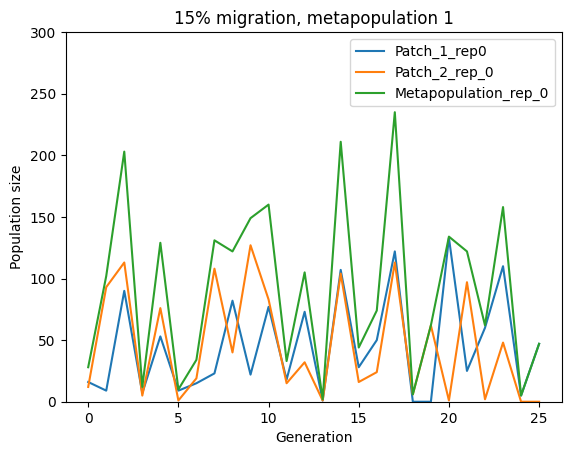

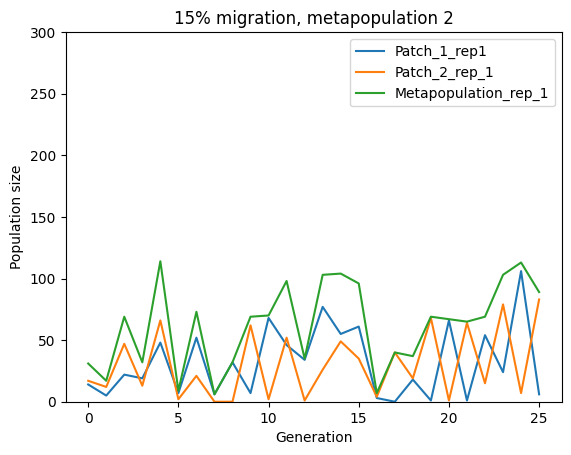

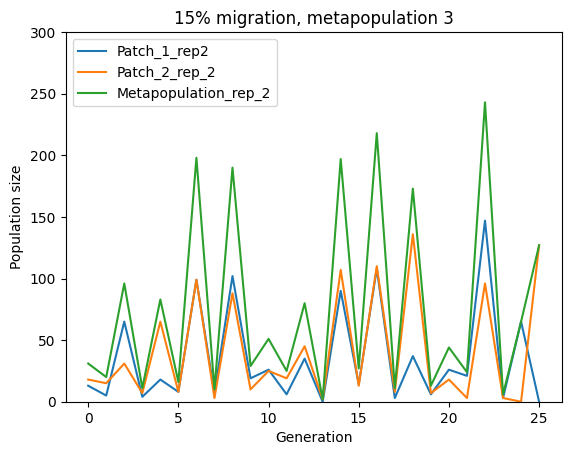

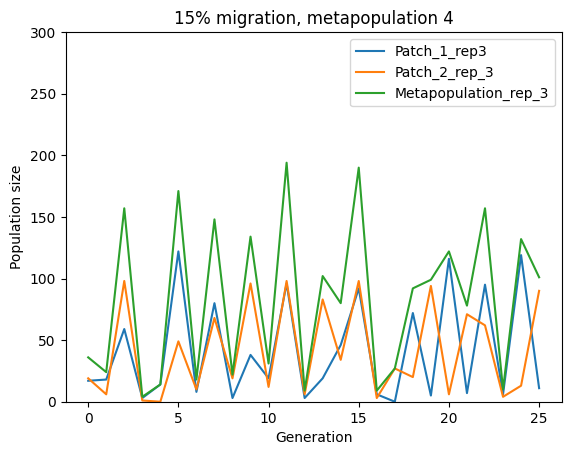

In [263]:
# plotting the time series for 15% migration

for i in range(4):
    plt.title(f"15% migration, metapopulation {i+1}")
    plt.ylim(0,300)
    plot_time_series(migration_15_nadult_matrix1,migration_15_nadult_matrix2,migration_15_metapop_nadult_matrix,[i])

In [264]:
for i in range(4):
    corr = np.corrcoef(migration_45_nadult_matrix1[:,i],migration_45_nadult_matrix2[:,i])
    print(corr[0,1])

0.8065119871728729
0.8755385047043278
0.6911386937742713
0.857687876251896


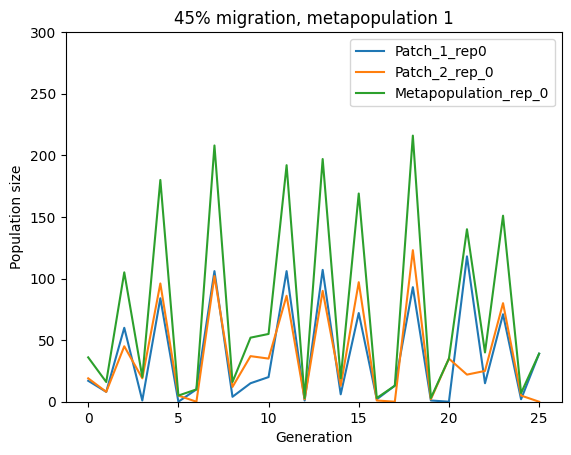

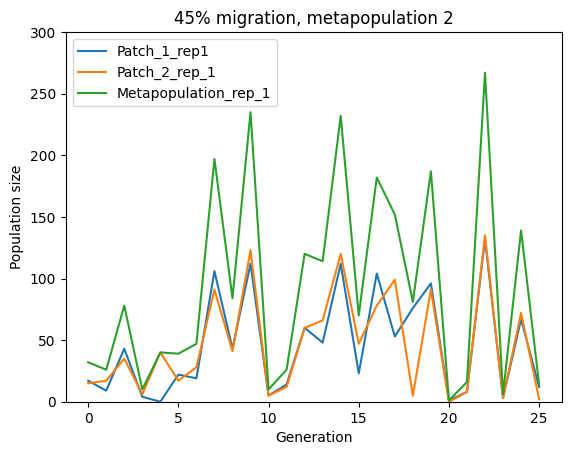

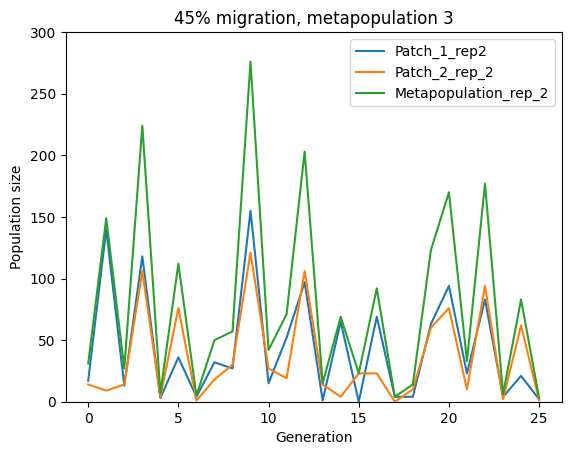

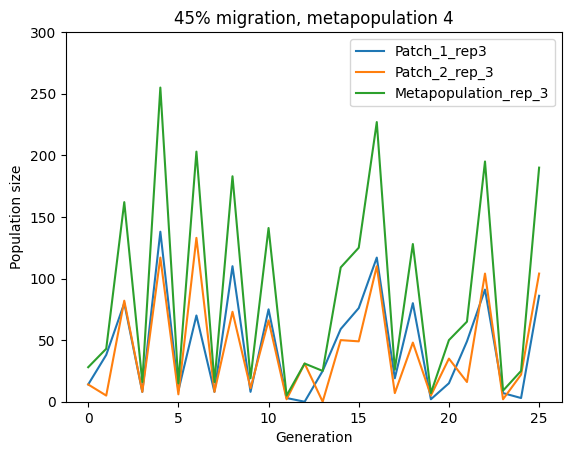

In [265]:
# plotting the time series for 45% migration

for i in range(4):
    plt.title(f"45% migration, metapopulation {i+1}")
    plt.ylim(0,300)
    plot_time_series(migration_45_nadult_matrix1,migration_45_nadult_matrix2,migration_45_metapop_nadult_matrix,[i])

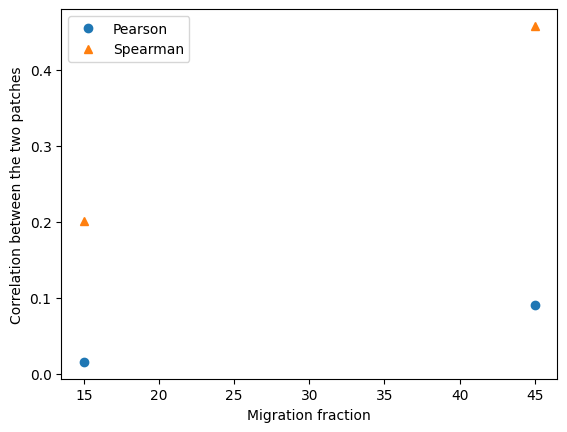

In [266]:
migration_15_nadult_matrix1, migration_15_nadult_matrix2, migration_15_metapop_nadult_matrix, migration_15_extinctions_matrix1, migration_15_extinctions_matrix2, migration_15_metapop_extinctions_matrix = patch_data(migration_15_data)
migration_45_nadult_matrix1, migration_45_nadult_matrix2, migration_45_metapop_nadult_matrix, migration_45_extinctions_matrix1, migration_45_extinctions_matrix2, migration_45_metapop_extinctions_matrix = patch_data(migration_45_data)

# comparing correlation between the two patches for 15% and 45% migration
# transform the time series data
migration_15_nadult_matrix1t = log_diff(migration_15_nadult_matrix1)
migration_15_nadult_matrix2t = log_diff(migration_15_nadult_matrix2)
migration_45_nadult_matrix1t = log_diff(migration_45_nadult_matrix1)
migration_45_nadult_matrix2t = log_diff(migration_45_nadult_matrix2)
# calculate the correlation
Pearson_corr_arr = [Pearson_corr_patches(migration_15_nadult_matrix1t,migration_15_nadult_matrix2t),Pearson_corr_patches(migration_45_nadult_matrix1t,migration_45_nadult_matrix2t)]
Spearman_corr_arr = [Spearman_corr_patches(migration_15_nadult_matrix1t,migration_15_nadult_matrix2t),Spearman_corr_patches(migration_45_nadult_matrix1t,migration_45_nadult_matrix2t)]
# plot the correlation
migration_arr = [15,45]
plt.figure()
plt.plot(migration_arr,Pearson_corr_arr,'o')
plt.plot(migration_arr,Spearman_corr_arr,'^')
plt.xlabel('Migration fraction') 
plt.ylabel('Correlation between the two patches')
plt.legend(['Pearson','Spearman'])
plt.show()

In [267]:
### average population size, FI, coefficient of variation (CV), and first and second autocorrelation lags
# we will do paramatrization for 45% migration, using the 4 replicates of patch 1 
# calculate the mean values for each of the above quantities for 4 replicates of patch 1 of 45% migration

# mean population size
mean_pop_size = round(np.mean(migration_45_nadult_matrix1))


# mean FI
mean_FI = np.mean(FI_numadult_matrix(migration_45_nadult_matrix1)[0])

# mean CV
mean_CV = np.std(migration_45_nadult_matrix1)/np.mean(migration_45_nadult_matrix1)


'''

mean_autocrr_lag1 = autocrr_lag1(migration_45_nadult_matrix1)
mean_autocrr_lag2 = autocrr_lag2(migration_45_nadult_matrix1)

'''

'\n\nmean_autocrr_lag1 = autocrr_lag1(migration_45_nadult_matrix1)\nmean_autocrr_lag2 = autocrr_lag2(migration_45_nadult_matrix1)\n\n'

In [268]:
# mean first and second autocorrelation lags

def autocrr_lag1(numadult_matrix):
    #numadult_matrixt = log_diff(numadult_matrix)
    if numadult_matrix.ndim == 1:
        numadult_matrix = np.expand_dims(numadult_matrix,axis=1)
    reps = np.shape(numadult_matrix)[1]
    gens = np.shape(numadult_matrix)[0]
    autocrr_lag1_arr = np.zeros(reps) # array of autocorrelation lag 1 for each replicate
    for i in range(reps):
        autocrr_lag1_arr[i] = np.correlate(numadult_matrix[:,i],numadult_matrix[1:,i],"full")[gens - 1]
    return np.mean(autocrr_lag1_arr)

def autocrr_lag2(numadult_matrix):
    if numadult_matrix.ndim == 1:
        numadult_matrix = np.expand_dims(numadult_matrix,axis=1)
    reps = np.shape(numadult_matrix)[1]
    gens = np.shape(numadult_matrix)[0]
    autocrr_lag1_arr = np.zeros(reps) # array of autocorrelation lag 1 for each replicate
    for i in range(reps):
        autocrr_lag1_arr[i] = np.correlate(numadult_matrix[:,i],numadult_matrix[1:,i],"full")[gens + 1]
    return np.mean(autocrr_lag1_arr)

In [269]:

# now we find the choice of parameters for food, sen_adden, sen_adsize and adnut that gives the closest match to the mean values of the above quantities
# for each combination , we will do 50 simulations and take the mean of the above quantities 

#  first try with values from the 2019 paper ( food = 1.76,  sen_adsize = 1.7, sen_adden = 0.17, adnut = 1.49 )
f = 0.45
food = 1.76
sen_adsize = 1.7
sen_adden = 0.17
numegg = 18 # why 18?
adnut = 1.49
generations = 25
replicates = 50
LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)

sim_mean_pop_size = round(np.mean(LHLH_numadult_matrix1))
sim_mean_FI = np.mean(FI_numadult_matrix(LHLH_numadult_matrix1)[0])
sim_mean_CV = np.std(LHLH_numadult_matrix1)/np.mean(LHLH_numadult_matrix1)
sim_mean_autocrr_lag1 = autocrr_lag1(LHLH_numadult_matrix1)
sim_mean_autocrr_lag2 = autocrr_lag2(LHLH_numadult_matrix1)


In [270]:
FI_numadult_matrix(np.array([1,2,3,4]))[1]

0.0

In [271]:
def cost_function(exp_data_patch_1,sim_data_patch_1):
    exp_mean_pop_size = round(np.mean(exp_data_patch_1))
    exp_mean_FI = np.mean(FI_numadult_matrix(exp_data_patch_1)[0])
    exp_mean_CV = np.std(exp_data_patch_1)/np.mean(exp_data_patch_1)
    exp_mean_autocrr_lag1 = autocrr_lag1(exp_data_patch_1)
    exp_mean_autocrr_lag2 = autocrr_lag2(exp_data_patch_1)

    sim_mean_pop_size = round(np.mean(sim_data_patch_1))
    sim_mean_FI = np.mean(FI_numadult_matrix(sim_data_patch_1)[0])
    sim_mean_CV = np.std(sim_data_patch_1)/np.mean(sim_data_patch_1)
    sim_mean_autocrr_lag1 = autocrr_lag1(sim_data_patch_1)
    sim_mean_autocrr_lag2 = autocrr_lag2(sim_data_patch_1)

    cost = abs((exp_mean_pop_size - sim_mean_pop_size)/exp_mean_pop_size) + abs((exp_mean_FI - sim_mean_FI)/exp_mean_FI) + abs((exp_mean_CV - sim_mean_CV)/exp_mean_CV) + abs((exp_mean_autocrr_lag1 - sim_mean_autocrr_lag1)/exp_mean_autocrr_lag1) + abs((exp_mean_autocrr_lag2 - sim_mean_autocrr_lag2)/exp_mean_autocrr_lag2)
    return cost

 

In [272]:
cost_function(migration_45_nadult_matrix1,LHLH_numadult_matrix1)

1.8864971782524627

In [273]:
#  8 values of food × 58 sen_adden × 20 sen_adsize × 14 adnut =  129,920 combinations
# the number of individual parameters (low like 8 or high like 58) has been decided based on the importance of the parameter in affecting the dynamics
food_arr = np.arange(1.16,2.76,0.2) # 8 values
sen_adden_arr = np.arange(0.01,0.59,0.01) # 58 values
sen_adsize_arr = np.arange(0.2,2.2,0.1) # 20 values
adnut_arr = np.arange(1.07,2.05,0.07) # 14 values


In [274]:
# create all possible combinations of the above parameters
from itertools import product
parameters = [food_arr,sen_adden_arr,sen_adsize_arr,adnut_arr]
combinations = list(product(*parameters))
len(combinations)

129920

In [275]:
# for each combination, do 50 simulations and calculate the cost function. 
# store the combination and the cost function in a 2D array

combn_cost_funcn_arr = np.zeros([len(combinations),5]) # 1st column is food, 2nd column is sen_adden, 3rd column is sen_adsize, 4th column is adnut, 5th column is cost function
for i in range(len(combinations)):
    food = combinations[i][0]
    sen_adden = combinations[i][1]
    sen_adsize = combinations[i][2]
    adnut = combinations[i][3]
    generations = 25
    replicates = 50
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    combn_cost_funcn_arr[i,0] = food
    combn_cost_funcn_arr[i,1] = sen_adden
    combn_cost_funcn_arr[i,2] = sen_adsize
    combn_cost_funcn_arr[i,3] = adnut
    combn_cost_funcn_arr[i,4] = cost_function(migration_45_nadult_matrix1,LHLH_numadult_matrix1)

# find the combination with the lowest cost function
min_cost_index = np.argmin(combn_cost_funcn_arr[:,4])
optimum_params = combn_cost_funcn_arr[min_cost_index,0:4]
print(optimum_params)



'\ncombn_cost_funcn_arr = np.zeros([len(combinations),5]) # 1st column is food, 2nd column is sen_adden, 3rd column is sen_adsize, 4th column is adnut, 5th column is cost function\nfor i in range(len(combinations)):\n    food = combinations[i][0]\n    sen_adden = combinations[i][1]\n    sen_adsize = combinations[i][2]\n    adnut = combinations[i][3]\n    generations = 25\n    replicates = 50\n    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)\n    combn_cost_funcn_arr[i,0] = food\n    combn_cost_funcn_arr[i,1] = sen_adden\n    combn_cost_funcn_arr[i,2] = sen_adsize\n    combn_cost_funcn_arr[i,3] = adnut\n    combn_cost_funcn_arr[i,4] = cost_function(migration_45_nadult_matrix1,LHLH_numadult_matrix1)\n\n# find the combination with the lowest cost function\nmin_cost_index = np.argmin(combn_cost_funcn_arr[:,4])\noptimum_par

In [277]:
np.random.seed(0)
Metapop_Simulation(numegg,optimum_params[0],optimum_params[3],numegg,optimum_params[0],optimum_params[3],10,1)

NameError: name 'optimum_params' is not defined

In [ ]:
# store the cost function array in a csv file
np.savetxt("cost_function_array.csv",combn_cost_funcn_arr,delimiter=",")

In [ ]:
# read the cost function array from the csv file
combn_cost_funcn_arr = np.loadtxt("cost_function_array.csv",delimiter=",")

In [ ]:
min_cost_index = np.argmin(combn_cost_funcn_arr[:,4])
optimum_params = combn_cost_funcn_arr[min_cost_index,0:4]

In [ ]:
optimum_params

array([2.16, 0.08, 0.6 , 1.42])

In [ ]:
migration_45_nadult_matrix1[:,0]

array([ 17.,   8.,  60.,   1.,  84.,   0.,  10., 106.,   4.,  15.,  20.,
       106.,   1., 107.,   6.,  72.,   2.,  13.,  93.,   1.,   0., 118.,
        15.,  71.,   2.,  39.])

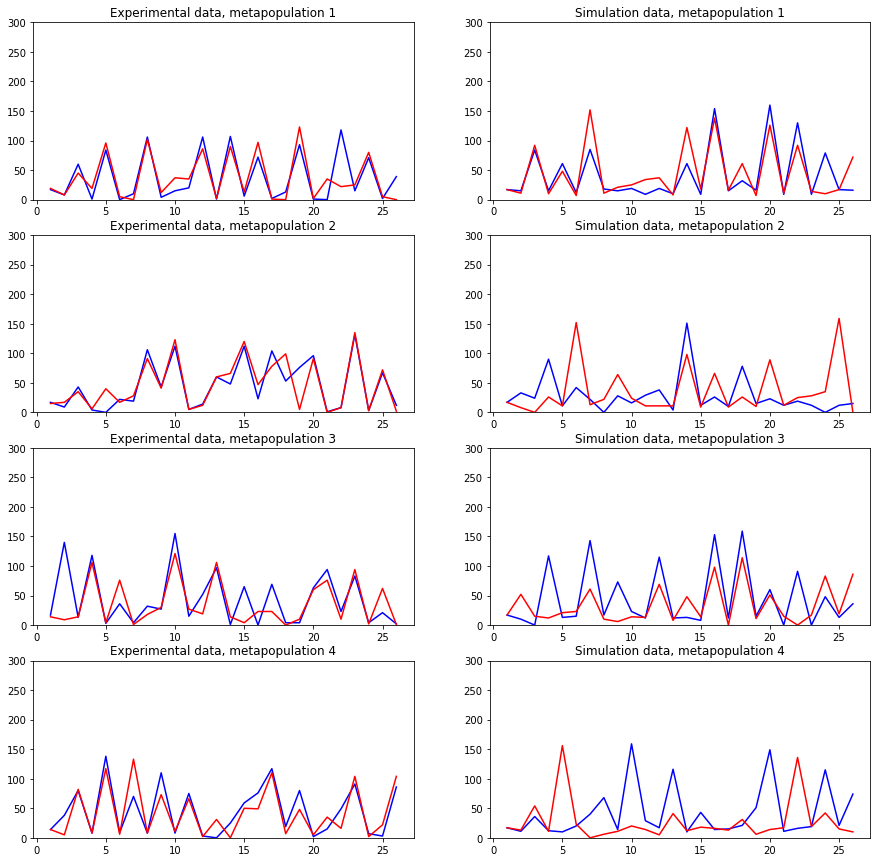

In [ ]:
# do 50 simulations with the optimum parameters and see how well patch 2 is predicted
food = optimum_params[0]
sen_adden = optimum_params[1]
sen_adsize = optimum_params[2]
adnut = optimum_params[3]
generations = 26
replicates = 50
LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)

# plotting the time series for the experimental data and the simulation data side by side
fig, axs = plt.subplots(4, 2,figsize=(15,15))
for i in range(4):
    axs[i,0].plot(range(1,generations+1),migration_45_nadult_matrix1[:,i],'b-')
    axs[i,0].plot(range(1,generations+1),migration_45_nadult_matrix2[:,i],'r-')
    axs[i,0].set_title(f"Experimental data, metapopulation {i+1}")
    axs[i,0].set_ylim(0,300)
    axs[i,1].plot(range(1,generations+1),LHLH_numadult_matrix1[:,i],'b-')
    axs[i,1].plot(range(1,generations+1),LHLH_numadult_matrix2[:,i],'r-')
    axs[i,1].set_title(f"Simulation data, metapopulation {i+1}")
    axs[i,1].set_ylim(0,300)


In [ ]:
print(generations)
print(replicates)

In [ ]:
# above code takes a long time to run. So we will instead save the data as an sqlite database and then read it from there
import sqlite3
conn = sqlite3.connect('LHLH.db')
c = conn.cursor()
c.execute('''CREATE TABLE LHLH (food real, sen_adden real, sen_adsize real, adnut real, cost real)''')
generations = 26
replicates = 50
for i in range(len(combinations)):
    food = combinations[i][0]
    sen_adden = combinations[i][1]
    sen_adsize = combinations[i][2]
    adnut = combinations[i][3]
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    cost = cost_function(migration_45_nadult_matrix1,LHLH_numadult_matrix1)
    c.execute("INSERT INTO LHLH VALUES (?,?,?,?,?)",(food,sen_adden,sen_adsize,adnut,cost))
    conn.commit()
#conn.close()

#now we find the combination with the lowest cost function in the database itself
c.execute("SELECT * FROM LHLH WHERE cost = (SELECT MIN(cost) FROM LHLH)")
optimum_params = c.fetchone()
conn.close()
print(optimum_params)




(1.9599999999999997, 0.03, 0.2, 1.07, 0.19078957269658614)


In [ ]:
# import the data from the database
import sqlite3
conn = sqlite3.connect('LHLH.db')
c = conn.cursor()
c.execute("SELECT * FROM LHLH")
combn_cost_funcn_arr1 = c.fetchall()
conn.close()


In [ ]:
import numpy as np
combn_cost_funcn_arr1 = np.array(combn_cost_funcn_arr1)
min_cost_index1= np.argmin(combn_cost_funcn_arr1[:,4])
optimum_params1 = combn_cost_funcn_arr1[min_cost_index1,0:4]
print(optimum_params1)

[1.96 0.03 0.2  1.07]


In [ ]:
# do 50 simulations with the optimum parameters and see how well patch 2 is predicted
f = 0.45
numegg = 18
food = optimum_params1[0]
sen_adden = optimum_params1[1]
sen_adsize = optimum_params1[2]
adnut = optimum_params1[3]
generations = 26
replicates = 50
LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation1(numegg,food,adnut,numegg,food,adnut,generations,replicates)

# plotting the time series for the experimental data and the simulation data side by side
#fig, axs = plt.subplots(4, 2,figsize=(15,15))
#for i in range(4):
#    axs[i,0].plot(range(1,generations+1),migration_45_nadult_matrix1[:,i],'b-')
#    axs[i,0].plot(range(1,generations+1),migration_45_nadult_matrix2[:,i],'r-')
#    axs[i,0].set_title(f"Experimental data, metapopulation {i+1}")
#    axs[i,0].set_ylim(0,300)
#    axs[i,1].plot(range(1,generations+1),LHLH_numadult_matrix1[:,i],'b-')
#    axs[i,1].plot(range(1,generations+1),LHLH_numadult_matrix2[:,i],'r-')
#    axs[i,1].set_title(f"Simulation data, metapopulation {i+1}")
#    axs[i,1].set_ylim(0,300)

In [ ]:
# calculating the characteristics of the time series for the experimental data and the simulation data for patch 2
# mean population size
exp_mean_pop_size = round(np.mean(migration_45_nadult_matrix2))
sim_mean_pop_size = round(np.mean(LHLH_numadult_matrix2))
print("avg pop size patch 2:",exp_mean_pop_size,sim_mean_pop_size)

# mean FI
exp_mean_FI = np.mean(FI_numadult_matrix(migration_45_nadult_matrix2)[0])
sim_mean_FI = np.mean(FI_numadult_matrix(LHLH_numadult_matrix2)[0])
print("FI patch 2:",exp_mean_FI,sim_mean_FI)

# mean CV
exp_mean_CV = np.std(migration_45_nadult_matrix2)/np.mean(migration_45_nadult_matrix2)
sim_mean_CV = np.std(LHLH_numadult_matrix2)/np.mean(LHLH_numadult_matrix2)
print("CV patch 2:",exp_mean_CV,sim_mean_CV)

# mean first and second autocorrelation lags
exp_mean_autocrr_lag1 = autocrr_lag1(migration_45_nadult_matrix2)
exp_mean_autocrr_lag2 = autocrr_lag2(migration_45_nadult_matrix2)
sim_mean_autocrr_lag1 = autocrr_lag1(LHLH_numadult_matrix2)
sim_mean_autocrr_lag2 = autocrr_lag2(LHLH_numadult_matrix2)
print("autocrr_lag1 patch 2:",exp_mean_autocrr_lag1,sim_mean_autocrr_lag1)
print("autocrr_lag2 patch 2:",exp_mean_autocrr_lag2,sim_mean_autocrr_lag2)

# correlation between the two patches
exp_corr = [Pearson_corr_patches(migration_45_nadult_matrix1,migration_45_nadult_matrix2),Spearman_corr_patches(migration_45_nadult_matrix1,migration_45_nadult_matrix2)]
sim_corr = [Pearson_corr_patches(LHLH_numadult_matrix1,LHLH_numadult_matrix2),Spearman_corr_patches(LHLH_numadult_matrix1,LHLH_numadult_matrix2)]
print("correlation between the two patches:",exp_corr,sim_corr)


# cost function
cost = cost_function(migration_45_nadult_matrix2,LHLH_numadult_matrix2)
print("cost function:",cost)

avg pop size patch 2: 40 41
FI patch 2: 1.3277353192342598 1.3449774522080171
CV patch 2: 0.9917823697608518 1.0405080075100424
autocrr_lag1 patch 2: 84149.75 90259.74
autocrr_lag2 patch 2: 49189.0 56977.84
correlation between the two patches: [0.8184123563925246, 0.7256957320780996] [0.5491783833850542, 0.5613458841574477]
cost function: 0.318069179464402


In [ ]:
# less synchrony in the simulation data compared to the experimental data
# probably because of demographic stochasticity?



### Coarser range of parameters but 4-fold cross validation based on metapopulation data

In [282]:
#  4 values of food × 29 sen_adden × 10 sen_adsize × 7 adnut =  8,120 combinations
# the number of individual parameters (low like 8 or high like 58) has been decided based on the importance of the parameter in affecting the dynamics
food_arr = np.arange(1.16,2.76,0.4) # 4 values
sen_adden_arr = np.arange(0.01,0.59,0.02) # 29 values
sen_adsize_arr = np.arange(0.2,2.2,0.2) # 10 values
adnut_arr = np.arange(1.07,2.05,0.14) # 7 values


In [283]:
# create all possible combinations of the above parameters
from itertools import product
parameters = [food_arr,sen_adden_arr,sen_adsize_arr,adnut_arr]
combinations = list(product(*parameters))

In [280]:
len(combinations)

8120

In [286]:
# for each combination, do 50 simulations and calculate the cost function. 
# store the combination and the cost function in a 2D array
f = 0.45
numegg = 18
generations = 26
replicates = 50

for j in range(1,5): # metapopulation j is the validation set and the rest are the training set
    combn_cost_funcn_arr = np.zeros([len(combinations),5]) # 1st column is food, 2nd column is sen_adden, 3rd column is sen_adsize, 4th column is adnut, 5th column is cost function
    for i in range(len(combinations)):
        food = combinations[i][0]
        sen_adden = combinations[i][1]
        sen_adsize = combinations[i][2]
        adnut = combinations[i][3]
        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
        LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
        combn_cost_funcn_arr[i,0] = food
        combn_cost_funcn_arr[i,1] = sen_adden
        combn_cost_funcn_arr[i,2] = sen_adsize
        combn_cost_funcn_arr[i,3] = adnut
        # cost will be between all the exp metapopulations except j and all the sim metapopulations
        combn_cost_funcn_arr[i,4] = cost_function(migration_45_metapop_nadult_matrix[:,np.arange(4)!=j],LHLH_metapop_nadult_matrix)
    # store the cost function array in a csv file
    np.savetxt(f"cost_function_array{j}.csv",combn_cost_funcn_arr,delimiter=",") 

        

KeyboardInterrupt: 

In [285]:
# read the cost function array from the csv file
# find the combination with the lowest cost function 
# use that combination to do 50 simulations and see how well the patch j metapopulation is predicted
# do this for all j = 1,2,3,4
optimum_parameter_list = []
for j in range(1,5):
    # read the cost function array from the csv file
    combn_cost_funcn_arr = np.loadtxt(f"cost_function_array{j}.csv",delimiter=",")
    min_cost_index = np.argmin(combn_cost_funcn_arr[:,4])
    optimum_params = combn_cost_funcn_arr[min_cost_index,0:4]
    print(f"opt params when patch {j} is left out",optimum_params)
    optimum_parameter_list.append(optimum_params)
    print(f"training cost function when patch {j} is left out",combn_cost_funcn_arr[min_cost_index,4])
    # do 50 simulations with the optimum parameters and see how well patch j is predicted
    food = optimum_params[0]
    sen_adden = optimum_params[1]
    sen_adsize = optimum_params[2]
    adnut = optimum_params[3]
    generations = 26
    replicates = 50
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
    # calculate cost function between patch j of the experimental data and the whole of simulation data
    cost = cost_function(migration_45_metapop_nadult_matrix[:,j-1],LHLH_metapop_nadult_matrix)
    print(f"validation cost function when metapop replicate {j} is left out",cost)


print(optimum_parameter_list)


FileNotFoundError: cost_function_array1.csv not found.

In [ ]:
# compare sim results with randomised patch j time series
for j in range(1,5):
    # generate 50 randomised time series for patch j
    randomised_patch_j = np.zeros([generations,replicates])
    for i in range(replicates):
        randomised_patch_j[:,i] = np.random.permutation(migration_45_nadult_matrix1[:,j-1])
    # calculate cost function between patch j of the experimental data and the whole of randomised data
    cost = cost_function(migration_45_metapop_nadult_matrix[:,j-1],randomised_patch_j)
    print(f"cost function against randomised time series when patch {j} is left out",cost)



cost function against randomised time series when patch 1 is left out 2.325888355304179
cost function against randomised time series when patch 2 is left out 2.148851085455144
cost function against randomised time series when patch 3 is left out 2.1421003979491138
cost function against randomised time series when patch 4 is left out 2.254251335024496


In [ ]:

print(migration_45_nadult_matrix1)

# Alternative approach: simulate random time series 
# look at max and min values of the experimental patch j time series
# assume a uniform distribution between the max and min values
# generate 50 random time series for patch j

for j in range(1,5):
    # generate 50 randomised time series for patch j
    randomised_patch_j = np.zeros([generations,replicates])
    for i in range(replicates):
        randomised_patch_j[:,i] = np.random.uniform(np.min(migration_45_nadult_matrix1[:,j-1]),np.max(migration_45_nadult_matrix1[:,j-1]),generations)
    # calculate cost function between patch j of the experimental data and the whole of randomised data
    cost = cost_function(migration_45_metapop_nadult_matrix[:,j-1],randomised_patch_j)
    print(f"cost function against randomised time series when patch {j} is left out",cost)

NameError: name 'migration_45_nadult_matrix1' is not defined

In [ ]:
# compare sim results with randomised ne j time series

#metapopulation dynamics not patch dynamics

replicates = 50
for j in range(1,5):
    # generate 50 randomised time series for metaoiop j
    randomised_metapop_j = np.zeros([generations,replicates])
    for i in range(replicates):
        randomised_patch_j[:,i] = np.random.permutation(migration_45_nadult_matrix1[:,j-1])
    # calculate cost function between patch j of the experimental data and the whole of randomised data
    cost = cost_function(migration_45_metapop_nadult_matrix[:,j-1],randomised_patch_j)
    print(f"cost function against randomised time series when patch {j} is left out",cost)



In [1]:
#test parameters from 45% migration on 15% migration


food = 2.36
sen_adden = 0.065
sen_adsize = 1.25
adnut = 1.15
generations = 26
replicates = 50
f = 0.15
LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
# calculate cost function between patch j of the experimental data and the whole of simulation data
cost = cost_function(migration_15_metapop_nadult_matrix, LHLH_metapop_nadult_matrix)
print(cost)



NameError: name 'Metapop_Simulation' is not defined